In [1]:
import pandas as pd
import csv

In [2]:
df_fake = pd.read_csv("Fake1.csv")
df_true = pd.read_csv("True1.csv")

In [3]:
df_fake["Label"] = "Fake"
df_true["Label"] = "True"

In [4]:
df = pd.concat([df_fake,df_true])
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.head(5)

title  \
0  Senior U.S. Republican senator: 'Let Mr. Muell...   
1  Treasury Secretary Mnuchin was sent gift-wrapp...   
2  Exclusive: U.S. memo weakens guidelines for pr...   
3  U.S. military to accept transgender recruits o...   
4   Mueller Spokesman Just F-cked Up Donald Trump...   

                                                text label Label  
0  WASHINGTON (Reuters) - The special counsel inv...  REAL  True  
1  (Reuters) - A gift-wrapped package addressed t...  REAL  True  
2  NEW YORK (Reuters) - The U.S. Justice Departme...  REAL  True  
3  WASHINGTON (Reuters) - Transgender people will...  REAL  True  
4  Trump supporters and the so-called president s...  FAKE  Fake

In [6]:
df.isnull().sum()

title    0
text     0
label    0
Label    0
dtype: int64

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
#Creating Figure
fig, axes = plt.subplots(1,2, figsize = (15,6))
#Adding the histogram1 - Fake News
sns.histplot(df_fake.Label, palette = 'Set1', alpha = 0.5, ax = axes[0])
axes[0].tick_params(axis = 'x', rotation = 90)
axes[0].set_title('Fake News Subject')
#Adding the histogram2 - True News
sns.histplot(df_true.Label, palette = 'Set1', alpha = 0.5, ax = axes[1])
axes[1].tick_params(axis = 'x', rotation = 90)
axes[1].set_title('True  News Subject')
#Printing the count of Subject
print("Fake News Count : ",dict(df_fake.Label.value_counts()))
print("True News Count : ",dict(df_true.Label.value_counts()))

Fake News Count :  {'Fake': 29}
True News Count :  {'True': 29}


True    29
Fake    29
Name: Label, dtype: int64

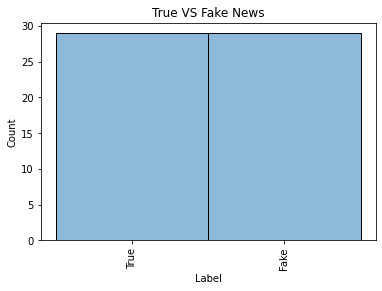

In [8]:
sns.histplot(df.Label, palette = 'Set1', alpha = 0.5)
plt.tick_params(axis = 'x', rotation = 90)
plt.title('True VS Fake News')
df.Label.value_counts()

In [9]:
df["text"] = df["title"]+df["text"] #considering text and title as X

In [10]:
df['Label'] = df['Label'].map({'True':1, 'Fake':0})


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Label'], stratify = df['Label'], test_size = 0.2, random_state = 10)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(46,)
(46,)
(12,)
(12,)


In [12]:
from transformers import AutoTokenizer
def tokenize(X):
    X = tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [14]:
X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)

In [15]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel

In [16]:
Length = 100

In [17]:
def get_model():
    dropout_rate = 0.2
    input_ids = Input(shape = (Length,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (Length,), dtype = tf.int32, name = 'input_mask')
    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)
    out = Dropout(0.2)(embeddings)
    #64 units dense layer
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)
    y = Dense(1,activation = 'sigmoid')(out)
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
   #define optimizer
    optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    return model

In [18]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
model = get_model()
tf.keras.utils.plot_model(model)

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [21]:
from keras.callbacks import EarlyStopping
history = model.fit(x = {'input_ids':X_train_tokens['input_ids'],'input_mask':X_train_tokens['attention_mask']}, y = y_train, epochs=3, validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping( monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)])

Epoch 1/3
1/1 [==============================] - 18s 18s/step - loss: 0.6612 - accuracy: 0.6111 - val_loss: 0.5265 - val_accuracy: 0.8000
Epoch 2/3
1/1 [==============================] - 27s 27s/step - loss: 0.6178 - accuracy: 0.6944 - val_loss: 0.5201 - val_accuracy: 0.8000
Epoch 3/3
1/1 [==============================] - 24s 24s/step - loss: 0.5720 - accuracy: 0.6944 - val_loss: 0.5141 - val_accuracy: 0.8000


In [22]:
import numpy as np
#yhat = np.where(model.predict({ 'input_ids' : X_train_tokens['input_ids'] , 'input_mask' : X_train_tokens['attention_mask']}) >=0.5,1,0)
yhat = np.where(model.predict({ 'input_ids' : X_test_tokens['input_ids'] , 'input_mask' : X_test_tokens['attention_mask']}) >=0.5,1,0)

1/1 [==============================] - 10s 10s/step


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.50      0.67         6

    accuracy                           0.75        12
   macro avg       0.83      0.75      0.73        12
weighted avg       0.83      0.75      0.73        12



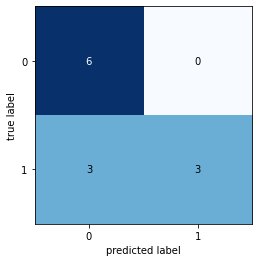

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix
matrix = confusion_matrix(y_test,yhat)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plot_confusion_matrix(conf_mat=matrix)
plt.show()

In [100]:
precision = matrix[0][0] / (matrix[0][0]+matrix[1][0])
print("Precision=",precision*100)
recall= matrix[0][0] / (matrix[0][0]+matrix[0][1])
print("Recall=",recall*100)
f_measure = (2*precision*recall) / (precision + recall)
print("F-Measure=",f_measure*100)

Precision= 100.0
Recall= 50.0
F-Measure= 66.66666666666666
